In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorrt
import tensorflow as tf

2023-06-10 20:33:32.263439: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.config.list_physical_devices()

2023-06-10 20:33:34.990908: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 256
x_test = x_test / 256
classes = (
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
)
display(x_train.shape)
display(y_train.shape)

(50000, 32, 32, 3)

(50000, 1)

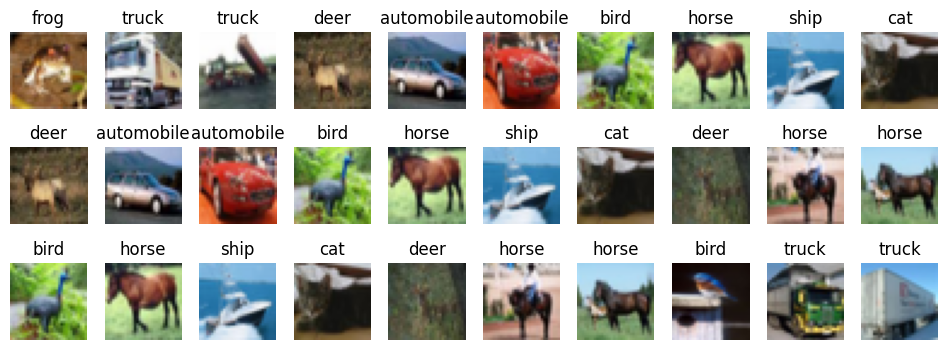

In [7]:
nrows = 3
ncols = 10
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4))
fig: plt.Figure = fig
fig.subplots_adjust(hspace=0.5)
for y in range(nrows):
    for x in range(ncols):
        index = y * nrows + x
        ax: plt.Axes = axes[y][x]
        image = x_train[index]
        ax.imshow(image)
        ax.set_axis_off()
        ax.set_title(classes[y_train[index][0]])
display()

# Infrastructure

In [7]:
# From the book
class ExponentialLearningRatePerBatch(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        self.rates.append(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs['loss'])
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [7]:
# From the notebook
# https://colab.research.google.com/github/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb#scrollTo=meIvy5u97YkD
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

In [8]:
# The find_learning_rate() function trains the model using
# the ExponentialLearningRate callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.
import math
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

In [9]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

# Model with regular normalization, no Batch Normalization

In [29]:
def build_model():
    model = tf.keras.models.Sequential()
    norm = tf.keras.layers.Normalization(name='norm', input_shape=(32, 32, 3))
    model.add(norm)
    model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
    for _ in range(20):
        model.add(tf.keras.layers.Dense(100, activation='swish', kernel_initializer='he_normal'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model

## Trying with SGD

In [13]:
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=[tf.keras.metrics.sparse_categorical_accuracy],
)
model.get_layer('norm').adapt(x_train)

In [14]:
lr_search = ExponentialLearningRatePerBatch(factor=1.005)
model.fit(x_train, y_train, epochs=1, callbacks=[lr_search], validation_split=0.1)

1407/1407 [==============================] - 17s 11ms/step - loss: 2.3037 - sparse_categorical_accuracy: 0.0921 - val_loss: 2.3024 - val_sparse_categorical_accuracy: 0.1142


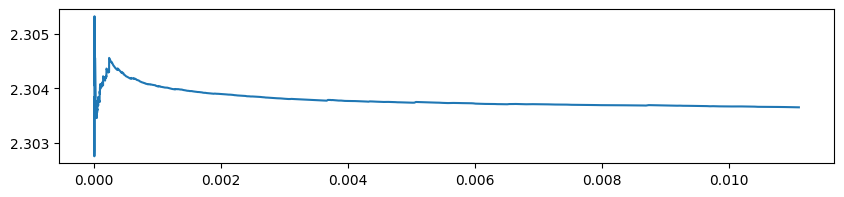

In [15]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(lr_search.rates, lr_search.losses)
display()

In [16]:
import numpy as np
import pandas as pd

In [17]:
df = pd.DataFrame(dict(lr=lr_search.rates, loss=lr_search.losses))
# df[df['loss'] > 2.4]
# df.iloc[1350:]
# lr = 0.01 / 2

In [19]:
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=[tf.keras.metrics.sparse_categorical_accuracy],
)
model.get_layer('norm').adapt(x_train)
log_dir = '01-sgd'
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir)
hist = model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stop_cb, tensorboard_cb]
)

Epoch 1/100
1407/1407 [==============================] - 15s 9ms/step - loss: 2.2136 - sparse_categorical_accuracy: 0.1700 - val_loss: 2.0645 - val_sparse_categorical_accuracy: 0.2296
Epoch 2/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.9497 - sparse_categorical_accuracy: 0.2746 - val_loss: 1.9385 - val_sparse_categorical_accuracy: 0.2802
Epoch 3/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.8032 - sparse_categorical_accuracy: 0.3338 - val_loss: 1.8714 - val_sparse_categorical_accuracy: 0.3060
Epoch 4/100
1407/1407 [==============================] - 12s 9ms/step - loss: 1.6900 - sparse_categorical_accuracy: 0.3762 - val_loss: 1.6876 - val_sparse_categorical_accuracy: 0.3880
Epoch 5/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.6089 - sparse_categorical_accuracy: 0.4157 - val_loss: 1.6205 - val_sparse_categorical_accuracy: 0.4230
Epoch 6/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.

In [20]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.6495 - sparse_categorical_accuracy: 0.4572


[1.649459719657898, 0.45719999074935913]

## Trying with Adam

In [28]:
model = build_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=[tf.keras.metrics.sparse_categorical_accuracy],
)
model.get_layer('norm').adapt(x_train)
lr_search = ExponentialLearningRatePerBatch(factor=1.005)
model.fit(x_train, y_train, epochs=1, callbacks=[lr_search], validation_split=0.1)

1407/1407 [==============================] - 21s 12ms/step - loss: 2.1085 - sparse_categorical_accuracy: 0.2058 - val_loss: 2.3516 - val_sparse_categorical_accuracy: 0.1072


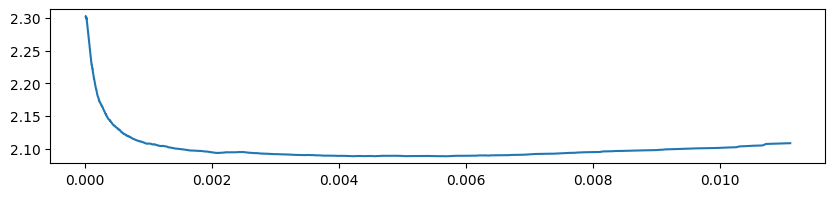

In [29]:
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(lr_search.rates, lr_search.losses)
display()

In [31]:
model = build_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=[tf.keras.metrics.sparse_categorical_accuracy],
)
model.get_layer('norm').adapt(x_train)
log_dir = '02-adam'
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir)
hist = model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stop_cb, tensorboard_cb]
)

Epoch 1/100
1407/1407 [==============================] - 18s 10ms/step - loss: 1.9468 - sparse_categorical_accuracy: 0.2726 - val_loss: 1.8616 - val_sparse_categorical_accuracy: 0.3032
Epoch 2/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.7472 - sparse_categorical_accuracy: 0.3639 - val_loss: 1.7515 - val_sparse_categorical_accuracy: 0.3730
Epoch 3/100
1407/1407 [==============================] - 15s 10ms/step - loss: 1.6632 - sparse_categorical_accuracy: 0.4012 - val_loss: 1.6590 - val_sparse_categorical_accuracy: 0.4080
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.6007 - sparse_categorical_accuracy: 0.4270 - val_loss: 1.6002 - val_sparse_categorical_accuracy: 0.4230
Epoch 5/100
1407/1407 [==============================] - 15s 10ms/step - loss: 1.5494 - sparse_categorical_accuracy: 0.4451 - val_loss: 1.6161 - val_sparse_categorical_accuracy: 0.4356
Epoch 6/100
1407/1407 [==============================] - 14s 10ms/step - lo

In [32]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.4905 - sparse_categorical_accuracy: 0.4948


[1.4904868602752686, 0.49480000138282776]

## Trying with Nadam

In [30]:
model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=[tf.keras.metrics.sparse_categorical_accuracy],
)
model.get_layer('norm').adapt(x_train)
log_dir = '02b-nadam'
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir)
hist = model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stop_cb, tensorboard_cb]
)

Epoch 1/100
1407/1407 [==============================] - 30s 17ms/step - loss: 1.9078 - sparse_categorical_accuracy: 0.2853 - val_loss: 1.8258 - val_sparse_categorical_accuracy: 0.3136
Epoch 2/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.7018 - sparse_categorical_accuracy: 0.3772 - val_loss: 1.6730 - val_sparse_categorical_accuracy: 0.4016
Epoch 3/100
1407/1407 [==============================] - 25s 18ms/step - loss: 1.6072 - sparse_categorical_accuracy: 0.4214 - val_loss: 1.5873 - val_sparse_categorical_accuracy: 0.4350
Epoch 4/100
1407/1407 [==============================] - 29s 20ms/step - loss: 1.5331 - sparse_categorical_accuracy: 0.4488 - val_loss: 1.5854 - val_sparse_categorical_accuracy: 0.4370
Epoch 5/100
1407/1407 [==============================] - 25s 18ms/step - loss: 1.4826 - sparse_categorical_accuracy: 0.4712 - val_loss: 1.5773 - val_sparse_categorical_accuracy: 0.4616
Epoch 6/100
1407/1407 [==============================] - 25s 18ms/step - lo

In [31]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.5007 - sparse_categorical_accuracy: 0.4887


[1.500705599784851, 0.4887000024318695]

# Trying without a normalization layer

## With SGD

In [1]:
def build_model_no_norm():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
    for _ in range(20):
        model.add(tf.keras.layers.Dense(100, activation='swish', kernel_initializer='he_normal'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model

In [9]:
model = build_model_no_norm()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=['accuracy']
)
lr_search = ExponentialLearningRatePerBatch(factor=1.005)
model.fit(
    x_train,
    y_train,
    epochs=1,
    callbacks=[lr_search],
    validation_split=0.1
)

NameError: name 'ExponentialLearningRatePerBatch' is not defined

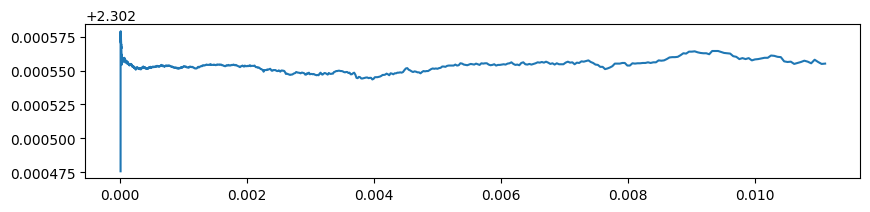

In [45]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(lr_search.rates, lr_search.losses)

In [11]:
model = build_model_no_norm()
optimizer = tf.keras.optimizers.SGD() # learning_rate=0.004)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=['accuracy']
)
tensorboard_cb = tf.keras.callbacks.TensorBoard('03-sgd-no-norm')
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
hist = model.fit(
    x_train,
    y_train,
    epochs=100,
    callbacks=[early_stop_cb, tensorboard_cb],
    validation_split=0.1
)

Epoch 1/100


2023-06-10 12:51:09.199735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-10 12:51:09.214686: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7faf02778550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-10 12:51:09.214736: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-06-10 12:51:11.252450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-06-10 12:51:11.320304: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-10 12:51:11.388965: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 [==============================] - 19s 9ms/step - loss: 2.3017 - accuracy: 0.1050 - val_loss: 2.2588 - val_accuracy: 0.1200
Epoch 2/100
1407/1407 [==============================] - 13s 9ms/step - loss: 2.1132 - accuracy: 0.2073 - val_loss: 2.1298 - val_accuracy: 0.1884
Epoch 3/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.9621 - accuracy: 0.2657 - val_loss: 1.9227 - val_accuracy: 0.2714
Epoch 4/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.8839 - accuracy: 0.3051 - val_loss: 1.8571 - val_accuracy: 0.3212
Epoch 5/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.8093 - accuracy: 0.3418 - val_loss: 1.8705 - val_accuracy: 0.3142
Epoch 6/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.7470 - accuracy: 0.3661 - val_loss: 1.7868 - val_accuracy: 0.3428
Epoch 7/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.6990 - accuracy: 0.3856 - val_loss: 1.7623 - val_accu

In [13]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.6622 - accuracy: 0.4295


[1.6621999740600586, 0.429500013589859]

## With Adam

In [14]:
model = build_model_no_norm()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=['accuracy']
)
lr_search = ExponentialLearningRatePerBatch(factor=1.005)
model.fit(
    x_train,
    y_train,
    epochs=1,
    callbacks=[lr_search],
    validation_split=0.1
)

2023-06-10 12:56:54.422974: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1407/1407 [==============================] - 20s 11ms/step - loss: 5.4734 - accuracy: 0.1768 - val_loss: 3.3809 - val_accuracy: 0.0970


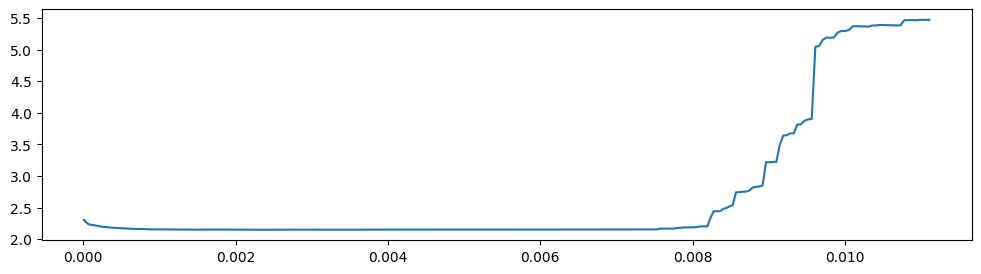

In [15]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(lr_search.rates, lr_search.losses)

In [20]:
model = build_model_no_norm()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=['accuracy']
)
tensorboard_cb = tf.keras.callbacks.TensorBoard('04-adam-no-norm')
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
hist = model.fit(
    x_train,
    y_train,
    epochs=100,
    callbacks=[early_stop_cb, tensorboard_cb],
    validation_split=0.1
)

Epoch 1/100
1407/1407 [==============================] - 22s 12ms/step - loss: 2.0341 - accuracy: 0.2200 - val_loss: 1.9653 - val_accuracy: 0.2720
Epoch 2/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.8682 - accuracy: 0.3003 - val_loss: 1.8502 - val_accuracy: 0.3314
Epoch 3/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.7823 - accuracy: 0.3503 - val_loss: 1.7390 - val_accuracy: 0.3668
Epoch 4/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.7182 - accuracy: 0.3767 - val_loss: 1.7250 - val_accuracy: 0.3784
Epoch 5/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.6779 - accuracy: 0.3946 - val_loss: 1.6914 - val_accuracy: 0.3946
Epoch 6/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.6376 - accuracy: 0.4109 - val_loss: 1.7407 - val_accuracy: 0.3748
Epoch 7/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.6087 - accuracy: 0.4195 - val_loss: 1

In [21]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.5889 - accuracy: 0.4417


[1.5889272689819336, 0.4417000114917755]

## With Nadam

In [22]:
model = build_model_no_norm()
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-5)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=['accuracy']
)
lr_search = ExponentialLearningRatePerBatch(factor=1.005)
model.fit(
    x_train,
    y_train,
    epochs=1,
    callbacks=[lr_search],
    validation_split=0.1
)

1407/1407 [==============================] - 34s 19ms/step - loss: 5.1671 - accuracy: 0.1858 - val_loss: 39.4151 - val_accuracy: 0.0970


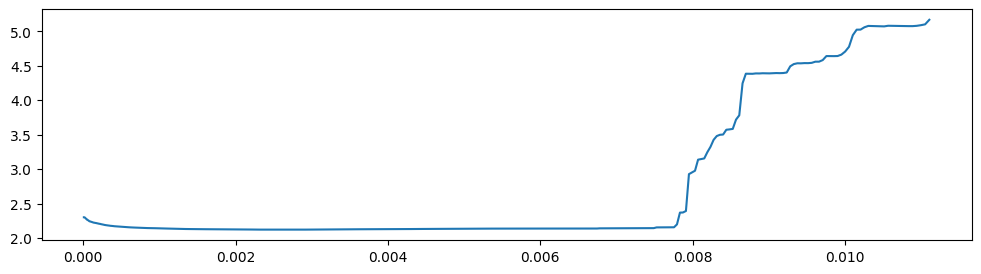

In [23]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(lr_search.rates, lr_search.losses)

In [24]:
model = build_model_no_norm()
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0008)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=['accuracy']
)
tensorboard_cb = tf.keras.callbacks.TensorBoard('05-nadam-no-norm')
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
hist = model.fit(
    x_train,
    y_train,
    epochs=100,
    callbacks=[early_stop_cb, tensorboard_cb],
    validation_split=0.1
)

Epoch 1/100
1407/1407 [==============================] - 29s 17ms/step - loss: 1.9883 - accuracy: 0.2388 - val_loss: 1.8610 - val_accuracy: 0.2992
Epoch 2/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.8205 - accuracy: 0.3222 - val_loss: 1.7935 - val_accuracy: 0.3464
Epoch 3/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.7293 - accuracy: 0.3733 - val_loss: 1.7370 - val_accuracy: 0.3834
Epoch 4/100
1407/1407 [==============================] - 25s 18ms/step - loss: 1.6745 - accuracy: 0.3963 - val_loss: 1.6628 - val_accuracy: 0.4028
Epoch 5/100
1407/1407 [==============================] - 23s 17ms/step - loss: 1.6307 - accuracy: 0.4158 - val_loss: 1.6268 - val_accuracy: 0.4262
Epoch 6/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.5969 - accuracy: 0.4267 - val_loss: 1.6493 - val_accuracy: 0.4122
Epoch 7/100
1407/1407 [==============================] - 23s 17ms/step - loss: 1.5670 - accuracy: 0.4412 - val_loss: 1

In [25]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 5ms/step - loss: 1.5669 - accuracy: 0.4556


[1.5668953657150269, 0.45559999346733093]

In [26]:
model = build_model_no_norm()
optimizer = tf.keras.optimizers.Nadam()
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=['accuracy']
)
tensorboard_cb = tf.keras.callbacks.TensorBoard('06-nadam-defaults-no-norm')
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
hist = model.fit(
    x_train,
    y_train,
    epochs=100,
    callbacks=[early_stop_cb, tensorboard_cb],
    validation_split=0.1
)

Epoch 1/100
1407/1407 [==============================] - 34s 20ms/step - loss: 1.9938 - accuracy: 0.2436 - val_loss: 1.8693 - val_accuracy: 0.3030
Epoch 2/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.8099 - accuracy: 0.3361 - val_loss: 1.8428 - val_accuracy: 0.3112
Epoch 3/100
1407/1407 [==============================] - 26s 19ms/step - loss: 1.7312 - accuracy: 0.3720 - val_loss: 1.7196 - val_accuracy: 0.3646
Epoch 4/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.6726 - accuracy: 0.3954 - val_loss: 1.7695 - val_accuracy: 0.3674
Epoch 5/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.6439 - accuracy: 0.4089 - val_loss: 1.6771 - val_accuracy: 0.4168
Epoch 6/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.6168 - accuracy: 0.4200 - val_loss: 1.6578 - val_accuracy: 0.4136
Epoch 7/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.5951 - accuracy: 0.4293 - val_loss: 1

In [27]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.6049 - accuracy: 0.4295


[1.6048800945281982, 0.429500013589859]

# Adding batch normalization

In [34]:
def build_model_bn_no_norm():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
    for _ in range(20):
        model.add(tf.keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('swish'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model

In [36]:
model = build_model_bn_no_norm()
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=['accuracy']
)
lr_search = ExponentialLearningRatePerBatch(factor=1.005)
model.fit(
    x_train,
    y_train,
    epochs=1,
    validation_split=0.1,
    callbacks=[lr_search]
)

1407/1407 [==============================] - 46s 26ms/step - loss: 2.2987 - accuracy: 0.1560 - val_loss: 4.8346 - val_accuracy: 0.1372


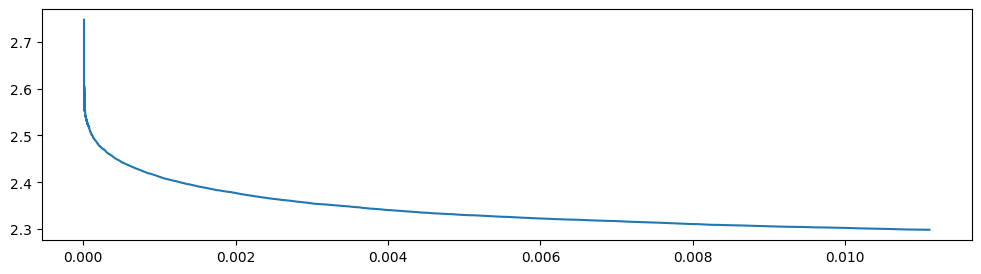

In [37]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(lr_search.rates, lr_search.losses)

## Adam default

In [38]:
model = build_model_bn_no_norm()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=['accuracy']
)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
tensorboard_cb = tf.keras.callbacks.TensorBoard('07-adam-default-bn')
model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stop_cb, tensorboard_cb]
)

Epoch 1/100
1407/1407 [==============================] - 42s 24ms/step - loss: 1.9798 - accuracy: 0.2761 - val_loss: 1.9657 - val_accuracy: 0.3118
Epoch 2/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.7557 - accuracy: 0.3715 - val_loss: 1.8832 - val_accuracy: 0.3342
Epoch 3/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.6614 - accuracy: 0.4079 - val_loss: 1.9922 - val_accuracy: 0.3176
Epoch 4/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.6034 - accuracy: 0.4281 - val_loss: 1.5447 - val_accuracy: 0.4444
Epoch 5/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.5489 - accuracy: 0.4488 - val_loss: 2.3245 - val_accuracy: 0.2692
Epoch 6/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.5017 - accuracy: 0.4647 - val_loss: 1.5210 - val_accuracy: 0.4548
Epoch 7/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.4573 - accuracy: 0.4839 - val_loss: 1

In [39]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 1.6053 - accuracy: 0.4498


[1.6052523851394653, 0.4498000144958496]

## Adam custom

In [42]:
model = build_model_bn_no_norm()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=['accuracy']
)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
tensorboard_cb = tf.keras.callbacks.TensorBoard('08-adam-custom-bn')
model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stop_cb, tensorboard_cb]
)

Epoch 1/100
1407/1407 [==============================] - 44s 25ms/step - loss: 2.0050 - accuracy: 0.2528 - val_loss: 1.9580 - val_accuracy: 0.2904
Epoch 2/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.8046 - accuracy: 0.3375 - val_loss: 1.8006 - val_accuracy: 0.3584
Epoch 3/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.7158 - accuracy: 0.3767 - val_loss: 1.7686 - val_accuracy: 0.3812
Epoch 4/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.6591 - accuracy: 0.4046 - val_loss: 1.9771 - val_accuracy: 0.3042
Epoch 5/100
1407/1407 [==============================] - 38s 27ms/step - loss: 1.6037 - accuracy: 0.4273 - val_loss: 1.7597 - val_accuracy: 0.3614
Epoch 6/100
1407/1407 [==============================] - 39s 28ms/step - loss: 1.5579 - accuracy: 0.4414 - val_loss: 1.6885 - val_accuracy: 0.4188
Epoch 7/100
1407/1407 [==============================] - 38s 27ms/step - loss: 1.5175 - accuracy: 0.4617 - val_loss: 1

In [43]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 1.6784 - accuracy: 0.4250


[1.6784380674362183, 0.42500001192092896]

## Nadam

In [44]:
model = build_model_bn_no_norm()
optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-5)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=['accuracy']
)
lr_search = ExponentialLearningRatePerBatch(factor=1.005)
model.fit(
    x_train,
    y_train,
    epochs=1,
    validation_split=0.1,
    callbacks=[lr_search]
)

1407/1407 [==============================] - 61s 35ms/step - loss: 2.2755 - accuracy: 0.1682 - val_loss: 7.2850 - val_accuracy: 0.1374


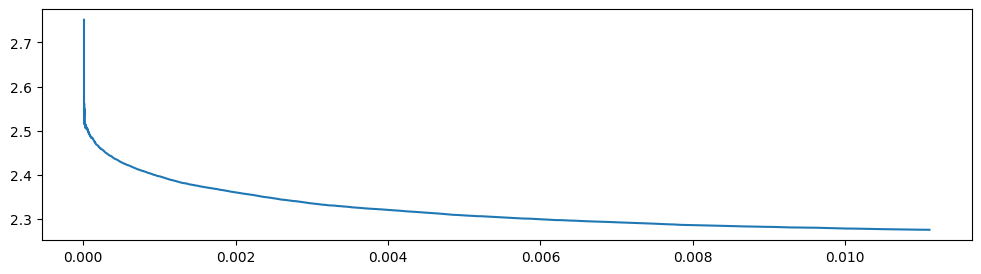

In [45]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(lr_search.rates, lr_search.losses)

In [46]:
model = build_model_bn_no_norm()
optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=['accuracy']
)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
tensorboard_cb = tf.keras.callbacks.TensorBoard('08-nadam-default-bn')
model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stop_cb, tensorboard_cb]
)

Epoch 1/100
1407/1407 [==============================] - 57s 33ms/step - loss: 1.9735 - accuracy: 0.2755 - val_loss: 1.8463 - val_accuracy: 0.3292
Epoch 2/100
1407/1407 [==============================] - 46s 32ms/step - loss: 1.7446 - accuracy: 0.3715 - val_loss: 2.0839 - val_accuracy: 0.3158
Epoch 3/100
1407/1407 [==============================] - 47s 33ms/step - loss: 1.6599 - accuracy: 0.4044 - val_loss: 1.8144 - val_accuracy: 0.3562
Epoch 4/100
1407/1407 [==============================] - 45s 32ms/step - loss: 1.5986 - accuracy: 0.4294 - val_loss: 1.5972 - val_accuracy: 0.4376
Epoch 5/100
1407/1407 [==============================] - 45s 32ms/step - loss: 1.5421 - accuracy: 0.4507 - val_loss: 1.7736 - val_accuracy: 0.3850
Epoch 6/100
1407/1407 [==============================] - 46s 33ms/step - loss: 1.5028 - accuracy: 0.4667 - val_loss: 1.6000 - val_accuracy: 0.4240
Epoch 7/100
1407/1407 [==============================] - 47s 33ms/step - loss: 1.4538 - accuracy: 0.4846 - val_loss: 1

In [47]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 1.5486 - accuracy: 0.4751


[1.5486000776290894, 0.47510001063346863]

## Book's nadam solution

In [11]:
import os

In [13]:
# The book uses these to evaluate models using model.evaluate(x_valid, y_vavlid)
x_valid, y_valid = x_train[:5000], y_train[:5000]
x_train_wo_valid, y_train_wo_valid = x_train[5000:], y_train[5000:]

In [53]:
model = build_model_bn_no_norm()
# Founds this after experimenting with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3,
# and choosing the one with the best validation performance after 20 epochs.
optimizer=tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    metrics=['accuracy']
)
dir = '09-nadam-book'
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(dir, save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(os.path.join(dir, 'tensorboard'))
model.fit(
    x_train_wo_valid,
    y_train_wo_valid,
    epochs=100,
    validation_data=[x_valid, y_valid],
    callbacks=[early_stop_cb, checkpoint_cb, tensorboard_cb]
)

Epoch 1/100
1407/1407 [==============================] - 64s 38ms/step - loss: 2.0565 - accuracy: 0.2417 - val_loss: 1.9418 - val_accuracy: 0.3102
Epoch 2/100
1407/1407 [==============================] - 53s 38ms/step - loss: 1.7880 - accuracy: 0.3559 - val_loss: 1.7863 - val_accuracy: 0.3528
Epoch 3/100
1407/1407 [==============================] - 53s 38ms/step - loss: 1.6814 - accuracy: 0.3974 - val_loss: 1.7411 - val_accuracy: 0.3716
Epoch 4/100
1407/1407 [==============================] - 54s 38ms/step - loss: 1.6245 - accuracy: 0.4221 - val_loss: 1.7065 - val_accuracy: 0.3912
Epoch 5/100
1407/1407 [==============================] - 48s 34ms/step - loss: 1.5666 - accuracy: 0.4439 - val_loss: 1.9037 - val_accuracy: 0.3440
Epoch 6/100
1407/1407 [==============================] - 54s 39ms/step - loss: 1.5156 - accuracy: 0.4628 - val_loss: 1.5928 - val_accuracy: 0.4196
Epoch 7/100
1407/1407 [==============================] - 47s 33ms/step - loss: 1.4689 - accuracy: 0.4788 - val_loss: 2

In [56]:
model.evaluate(x_valid, y_valid)

157/157 [==============================] - 1s 7ms/step - loss: 1.4642 - accuracy: 0.5062


[1.4641958475112915, 0.5062000155448914]

# SELU

## Infrastructure

In [67]:
def build_model_selu():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Normalization(input_shape=(32, 32, 3), name='norm'))
    model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
    for _ in range(20):
        model.add(tf.keras.layers.Dense(100, kernel_initializer='lecun_normal', activation='selu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model

In [13]:
def prep_model(lr, x_input):
    model = build_model_selu()
    optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
    model.compile(
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        optimizer=optimizer,
        metrics=['accuracy']
    )
    model.get_layer('norm').adapt(x_input)
    return model

## Finding the learning rate

In [14]:
lrs = [1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3]
histories = []
for lr in lrs:
    print('---------------------')
    print(lr)
    print('---------------------')
    model = prep_model(lr, x_train_wo_valid)
    histories.append(
        model.fit(
            x_train_wo_valid,
            y_train_wo_valid,
            validation_data=(x_valid, y_valid),
            epochs=10,
        )
    )

---------------------
1e-05
---------------------


2023-06-10 18:04:14.748432: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.


Epoch 1/10


2023-06-10 18:04:16.705338: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.


1405/1407 [============================>.] - ETA: 0s - loss: 2.0795 - accuracy: 0.2656

2023-06-10 18:04:28.614387: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 61440000 exceeds 10% of free system memory.


1407/1407 [==============================] - 12s 6ms/step - loss: 2.0793 - accuracy: 0.2656 - val_loss: 1.8858 - val_accuracy: 0.3198
Epoch 2/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.8293 - accuracy: 0.3468 - val_loss: 1.7830 - val_accuracy: 0.3568
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.7302 - accuracy: 0.3832 - val_loss: 1.7344 - val_accuracy: 0.3742
Epoch 4/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.6630 - accuracy: 0.4074 - val_loss: 1.6879 - val_accuracy: 0.3924
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.6101 - accuracy: 0.4285 - val_loss: 1.6614 - val_accuracy: 0.4096
Epoch 6/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.5649 - accuracy: 0.4441 - val_loss: 1.6480 - val_accuracy: 0.4132
Epoch 7/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.5286 - accuracy: 0.4539 - val_loss: 1.6261 - val_accuracy: 0.4198
Ep

2023-06-10 18:05:40.216873: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.


Epoch 1/10


2023-06-10 18:05:42.367669: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.


1407/1407 [==============================] - 12s 6ms/step - loss: 1.9254 - accuracy: 0.3154 - val_loss: 1.7590 - val_accuracy: 0.3690
Epoch 2/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.6871 - accuracy: 0.3978 - val_loss: 1.6534 - val_accuracy: 0.4060
Epoch 3/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.5817 - accuracy: 0.4366 - val_loss: 1.5950 - val_accuracy: 0.4316
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.5132 - accuracy: 0.4587 - val_loss: 1.5640 - val_accuracy: 0.4506
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4580 - accuracy: 0.4801 - val_loss: 1.5449 - val_accuracy: 0.4534
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4094 - accuracy: 0.4965 - val_loss: 1.5293 - val_accuracy: 0.4584
Epoch 7/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.3684 - accuracy: 0.5152 - val_loss: 1.5219 - val_accuracy: 0.4542
Ep

In [23]:
accuracy = [np.max(x.history['val_accuracy']) for x in histories]
pd.DataFrame(dict(lrs=lrs, accuracy=accuracy))

,lrs,accuracy
0,0.00001,0.4298
1,0.00003,0.4668
2,0.00005,0.4924
3,0.00010,0.4970
4,0.00030,0.4980
5,0.00050,0.5024
6,0.00100,0.4722


In [24]:
model = prep_model(4e-4, x_train_wo_valid)
hist = model.fit(
    x_train_wo_valid,
    y_train_wo_valid,
    validation_data=(x_valid, y_valid),
    epochs=10,
)

Epoch 1/10
1407/1407 [==============================] - 12s 6ms/step - loss: 1.8884 - accuracy: 0.3314 - val_loss: 1.7497 - val_accuracy: 0.3784
Epoch 2/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.6853 - accuracy: 0.4099 - val_loss: 1.6469 - val_accuracy: 0.4168
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.5884 - accuracy: 0.4448 - val_loss: 1.6033 - val_accuracy: 0.4384
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.5187 - accuracy: 0.4676 - val_loss: 1.5600 - val_accuracy: 0.4422
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4647 - accuracy: 0.4883 - val_loss: 1.5442 - val_accuracy: 0.4572
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4039 - accuracy: 0.5098 - val_loss: 1.5344 - val_accuracy: 0.4658
Epoch 7/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.3522 - accuracy: 0.5249 - val_loss: 1.5073 - val_accuracy

TypeError: 'History' object is not subscriptable

In [25]:
np.max(hist.history['val_accuracy'])

0.5054000020027161

## Training the model

In [26]:
model = prep_model(4e-4, x_train_wo_valid)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('10-selu/checkpoints', save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard('10-selu/tensorboard')
hist = model.fit(
    x_train_wo_valid,
    y_train_wo_valid,
    validation_data=(x_valid, y_valid),
    epochs=100,
    callbacks=[early_stop_cb, checkpoint_cb, tensorboard_cb]
)

Epoch 1/100
1404/1407 [============================>.] - ETA: 0s - loss: 1.8650 - accuracy: 0.3347

INFO:tensorflow:Assets written to: 10-selu/checkpoints/assets


INFO:tensorflow:Assets written to: 10-selu/checkpoints/assets


1407/1407 [==============================] - 14s 8ms/step - loss: 1.8645 - accuracy: 0.3348 - val_loss: 1.7512 - val_accuracy: 0.3788
Epoch 2/100
1400/1407 [============================>.] - ETA: 0s - loss: 1.6505 - accuracy: 0.4144

INFO:tensorflow:Assets written to: 10-selu/checkpoints/assets


INFO:tensorflow:Assets written to: 10-selu/checkpoints/assets


1407/1407 [==============================] - 10s 7ms/step - loss: 1.6499 - accuracy: 0.4146 - val_loss: 1.6157 - val_accuracy: 0.4268
Epoch 3/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.5571 - accuracy: 0.4490

INFO:tensorflow:Assets written to: 10-selu/checkpoints/assets


INFO:tensorflow:Assets written to: 10-selu/checkpoints/assets


1407/1407 [==============================] - 9s 6ms/step - loss: 1.5570 - accuracy: 0.4490 - val_loss: 1.5575 - val_accuracy: 0.4528
Epoch 4/100
1398/1407 [============================>.] - ETA: 0s - loss: 1.4808 - accuracy: 0.4790

INFO:tensorflow:Assets written to: 10-selu/checkpoints/assets


INFO:tensorflow:Assets written to: 10-selu/checkpoints/assets


1407/1407 [==============================] - 9s 6ms/step - loss: 1.4811 - accuracy: 0.4790 - val_loss: 1.5279 - val_accuracy: 0.4632
Epoch 5/100
1407/1407 [==============================] - ETA: 0s - loss: 1.4215 - accuracy: 0.5003

INFO:tensorflow:Assets written to: 10-selu/checkpoints/assets


INFO:tensorflow:Assets written to: 10-selu/checkpoints/assets


1407/1407 [==============================] - 10s 7ms/step - loss: 1.4215 - accuracy: 0.5003 - val_loss: 1.4978 - val_accuracy: 0.4726
Epoch 6/100
1401/1407 [============================>.] - ETA: 0s - loss: 1.3661 - accuracy: 0.5203

INFO:tensorflow:Assets written to: 10-selu/checkpoints/assets


INFO:tensorflow:Assets written to: 10-selu/checkpoints/assets


1407/1407 [==============================] - 9s 6ms/step - loss: 1.3664 - accuracy: 0.5202 - val_loss: 1.4807 - val_accuracy: 0.4798
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3173 - accuracy: 0.5411 - val_loss: 1.4996 - val_accuracy: 0.4864
Epoch 8/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.2781 - accuracy: 0.5545 - val_loss: 1.5056 - val_accuracy: 0.4836
Epoch 9/100
1398/1407 [============================>.] - ETA: 0s - loss: 1.2327 - accuracy: 0.5740

INFO:tensorflow:Assets written to: 10-selu/checkpoints/assets


INFO:tensorflow:Assets written to: 10-selu/checkpoints/assets


1407/1407 [==============================] - 9s 7ms/step - loss: 1.2330 - accuracy: 0.5739 - val_loss: 1.4630 - val_accuracy: 0.4930
Epoch 10/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.1977 - accuracy: 0.5857 - val_loss: 1.4938 - val_accuracy: 0.4926
Epoch 11/100
1399/1407 [============================>.] - ETA: 0s - loss: 1.1637 - accuracy: 0.5956

INFO:tensorflow:Assets written to: 10-selu/checkpoints/assets


INFO:tensorflow:Assets written to: 10-selu/checkpoints/assets


1407/1407 [==============================] - 10s 7ms/step - loss: 1.1641 - accuracy: 0.5955 - val_loss: 1.4416 - val_accuracy: 0.5090
Epoch 12/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.1292 - accuracy: 0.6110 - val_loss: 1.4978 - val_accuracy: 0.5044
Epoch 13/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.0999 - accuracy: 0.6203 - val_loss: 1.5105 - val_accuracy: 0.5016
Epoch 14/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0635 - accuracy: 0.6350 - val_loss: 1.4785 - val_accuracy: 0.5122
Epoch 15/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.0347 - accuracy: 0.6476 - val_loss: 1.4639 - val_accuracy: 0.5154
Epoch 16/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.0076 - accuracy: 0.6544 - val_loss: 1.5294 - val_accuracy: 0.4966
Epoch 17/100
1407/1407 [==============================] - 8s 6ms/step - loss: 0.9822 - accuracy: 0.6651 - val_loss: 1.5377 - val_accurac

In [27]:
model.evaluate(x_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.4416 - accuracy: 0.5090


[1.44163179397583, 0.5090000033378601]

In [29]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.4442 - accuracy: 0.5093


[1.4441536664962769, 0.5092999935150146]

# Alpha Dropout

## Infrastructure

In [59]:
def build_model_dropout():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Normalization(input_shape=(32, 32, 3), name='norm'))
    model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
    for _ in range(20):
        model.add(tf.keras.layers.Dense(100, kernel_initializer='lecun_normal', activation='selu'))
    model.add(tf.keras.layers.AlphaDropout(rate=0.1))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model

In [60]:
def prep_model_dropout(lr, x_input):
    model = build_model_dropout()
    optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
    model.compile(
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        optimizer=optimizer,
        metrics=['accuracy']
    )
    model.get_layer('norm').adapt(x_input)
    return model

## Finding the learning rate

In [33]:
lrs = [1e-5, 2.5e-5, 5e-5, 7.5e-5, 1e-4, 2.5e-4, 5e-4, 7.5e-4, 1e-3]
histories = []
for lr in lrs:
    print('---------------------')
    print(lr)
    print('---------------------')
    model = prep_model_dropout(lr, x_train_wo_valid)
    histories.append(
        model.fit(
            x_train_wo_valid,
            y_train_wo_valid,
            validation_data=(x_valid, y_valid),
            epochs=10,
        )
    )

---------------------
1e-05
---------------------
Epoch 1/10
1407/1407 [==============================] - 13s 6ms/step - loss: 2.3886 - accuracy: 0.2023 - val_loss: 1.9617 - val_accuracy: 0.3116
Epoch 2/10
1407/1407 [==============================] - 8s 6ms/step - loss: 2.0945 - accuracy: 0.2790 - val_loss: 1.8465 - val_accuracy: 0.3556
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.9544 - accuracy: 0.3206 - val_loss: 1.7926 - val_accuracy: 0.3784
Epoch 4/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.8517 - accuracy: 0.3482 - val_loss: 1.7526 - val_accuracy: 0.3950
Epoch 5/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.7793 - accuracy: 0.3728 - val_loss: 1.7208 - val_accuracy: 0.4052
Epoch 6/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.7208 - accuracy: 0.3915 - val_loss: 1.7092 - val_accuracy: 0.4112
Epoch 7/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.6672 - 

In [40]:
pd.DataFrame(dict(rates=lrs, accuracy=[np.max(x.history['val_accuracy']) for x in histories]))

,rates,accuracy
0,0.000010,0.4378
1,0.000025,0.4680
2,0.000050,0.4886
3,0.000075,0.5006
4,0.000100,0.4986
5,0.000250,0.5140
6,0.000500,0.4924
7,0.000750,0.4786
8,0.001000,0.4422


In [61]:
model = prep_model_dropout(2e-4, x_train_wo_valid)
hist = model.fit(
    x_train_wo_valid,
    y_train_wo_valid,
    validation_data=(x_valid, y_valid),
    epochs=10,
)

Epoch 1/10
1407/1407 [==============================] - 15s 8ms/step - loss: 1.9038 - accuracy: 0.3270 - val_loss: 1.6983 - val_accuracy: 0.3946
Epoch 2/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.6312 - accuracy: 0.4200 - val_loss: 1.6163 - val_accuracy: 0.4256
Epoch 3/10
1407/1407 [==============================] - 10s 7ms/step - loss: 1.5236 - accuracy: 0.4612 - val_loss: 1.5699 - val_accuracy: 0.4600
Epoch 4/10
1407/1407 [==============================] - 9s 7ms/step - loss: 1.4524 - accuracy: 0.4877 - val_loss: 1.5211 - val_accuracy: 0.4612
Epoch 5/10
1407/1407 [==============================] - 9s 7ms/step - loss: 1.3905 - accuracy: 0.5083 - val_loss: 1.5210 - val_accuracy: 0.4788
Epoch 6/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.3336 - accuracy: 0.5290 - val_loss: 1.5012 - val_accuracy: 0.4892
Epoch 7/10
1407/1407 [==============================] - 10s 7ms/step - loss: 1.2863 - accuracy: 0.5447 - val_loss: 1.5254 - val_accura

In [43]:
np.max(hist.history['val_accuracy'])

0.506600022315979

In [44]:
model = prep_model_dropout(3e-4, x_train_wo_valid)
hist = model.fit(
    x_train_wo_valid,
    y_train_wo_valid,
    validation_data=(x_valid, y_valid),
    epochs=10,
)

Epoch 1/10
1407/1407 [==============================] - 14s 7ms/step - loss: 1.8997 - accuracy: 0.3270 - val_loss: 1.7965 - val_accuracy: 0.3902
Epoch 2/10
1407/1407 [==============================] - 10s 7ms/step - loss: 1.6558 - accuracy: 0.4164 - val_loss: 1.7212 - val_accuracy: 0.4076
Epoch 3/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5560 - accuracy: 0.4511 - val_loss: 1.5966 - val_accuracy: 0.4600
Epoch 4/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.4861 - accuracy: 0.4811 - val_loss: 1.5890 - val_accuracy: 0.4726
Epoch 5/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.4298 - accuracy: 0.5005 - val_loss: 1.5805 - val_accuracy: 0.4750
Epoch 6/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.3760 - accuracy: 0.5231 - val_loss: 1.6405 - val_accuracy: 0.4730
Epoch 7/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.3290 - accuracy: 0.5376 - val_loss: 1.6089 - val_accurac

In [46]:
np.max(hist.history['val_accuracy'])

0.503000020980835

## Training the model

In [13]:
model = prep_model_dropout(2e-4, x_train_wo_valid)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('11-alpha-dropout/checkpoints', save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard('11-alpha-dropout/tensorboard')
hist = model.fit(
    x_train_wo_valid,
    y_train_wo_valid,
    validation_data=(x_valid, y_valid),
    epochs=100,
    callbacks=[early_stop_cb, checkpoint_cb, tensorboard_cb]
)

Epoch 1/100
1401/1407 [============================>.] - ETA: 0s - loss: 1.9127 - accuracy: 0.3274

2023-06-10 19:44:34.032839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100]
	 [[{{node inputs}}]]
2023-06-10 19:44:34.488688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: 11-alpha-dropout/checkpoints/assets


INFO:tensorflow:Assets written to: 11-alpha-dropout/checkpoints/assets


1407/1407 [==============================] - 16s 9ms/step - loss: 1.9121 - accuracy: 0.3276 - val_loss: 1.6769 - val_accuracy: 0.4034
Epoch 2/100
1404/1407 [============================>.] - ETA: 0s - loss: 1.6391 - accuracy: 0.4205

2023-06-10 19:44:45.759346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100]
	 [[{{node inputs}}]]
2023-06-10 19:44:46.160912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: 11-alpha-dropout/checkpoints/assets


INFO:tensorflow:Assets written to: 11-alpha-dropout/checkpoints/assets


1407/1407 [==============================] - 11s 8ms/step - loss: 1.6391 - accuracy: 0.4204 - val_loss: 1.5984 - val_accuracy: 0.4420
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.5340 - accuracy: 0.4598 - val_loss: 1.6003 - val_accuracy: 0.4648
Epoch 4/100
1401/1407 [============================>.] - ETA: 0s - loss: 1.4586 - accuracy: 0.4870

2023-06-10 19:45:08.318684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100]
	 [[{{node inputs}}]]
2023-06-10 19:45:08.763600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: 11-alpha-dropout/checkpoints/assets


INFO:tensorflow:Assets written to: 11-alpha-dropout/checkpoints/assets


1407/1407 [==============================] - 13s 9ms/step - loss: 1.4585 - accuracy: 0.4870 - val_loss: 1.5740 - val_accuracy: 0.4802
Epoch 5/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.3987 - accuracy: 0.5112 - val_loss: 1.6026 - val_accuracy: 0.4718
Epoch 6/100
1402/1407 [============================>.] - ETA: 0s - loss: 1.3453 - accuracy: 0.5292

2023-06-10 19:45:31.830016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100]
	 [[{{node inputs}}]]
2023-06-10 19:45:32.252635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: 11-alpha-dropout/checkpoints/assets


INFO:tensorflow:Assets written to: 11-alpha-dropout/checkpoints/assets


1407/1407 [==============================] - 12s 9ms/step - loss: 1.3453 - accuracy: 0.5290 - val_loss: 1.5366 - val_accuracy: 0.4898
Epoch 7/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.2946 - accuracy: 0.5485 - val_loss: 1.5551 - val_accuracy: 0.4906
Epoch 8/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.2538 - accuracy: 0.5595 - val_loss: 1.5877 - val_accuracy: 0.5006
Epoch 9/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.2105 - accuracy: 0.5776 - val_loss: 1.6095 - val_accuracy: 0.5078
Epoch 10/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.1721 - accuracy: 0.5894 - val_loss: 1.7100 - val_accuracy: 0.4932
Epoch 11/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.1321 - accuracy: 0.6023 - val_loss: 1.6397 - val_accuracy: 0.5046
Epoch 12/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.1007 - accuracy: 0.6159 - val_loss: 1.6262 - val_accuracy

In [20]:
model.evaluate(x_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.5366 - accuracy: 0.4898


[1.5365588665008545, 0.48980000615119934]

In [16]:
# Not the same because of dropout!
np.max(hist.history['val_accuracy'])

0.5174000263214111

In [19]:
loaded_model: tf.keras.Model = tf.keras.models.load_model('11-alpha-dropout/checkpoints')
loaded_model.evaluate(x_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.5366 - accuracy: 0.4898


[1.5365588665008545, 0.48980000615119934]

## Inferring with MC dropout

In [54]:
# Step 1: collect samples
y_probas = np.stack([model(x_valid, training=True) for sample in range(100)])

In [55]:
y_probas.shape

(100, 5000, 10)

In [56]:
# Step 2: average the samples
y_proba = y_probas.mean(axis=0)
y_proba.shape

(5000, 10)

In [58]:
y_hat = y_proba.argmax(axis=1)
display(y_hat.shape)
display(y_valid.reshape(-1).shape)
accuracy_vector = y_hat == y_valid.reshape(-1)
# t = len([x for x in accuracy_vector if x])
# f = len([x for x in accuracy_vector if not x])
# t / (t + f)
accuracy_vector.mean()

(5000,)

(5000,)

0.49

# 1-cycle learning rate scheduling

## Infrastructure

In [10]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

In [11]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [14]:
X_means = x_train_wo_valid.mean(axis=0)
X_stds = x_train_wo_valid.std(axis=0)
X_train_scaled = (x_train_wo_valid - X_means) / X_stds
X_valid_scaled = (x_valid - X_means) / X_stds
X_test_scaled = (x_test - X_means) / X_stds

352/352 [==============================] - 4s 8ms/step - loss: nan - accuracy: 0.1769


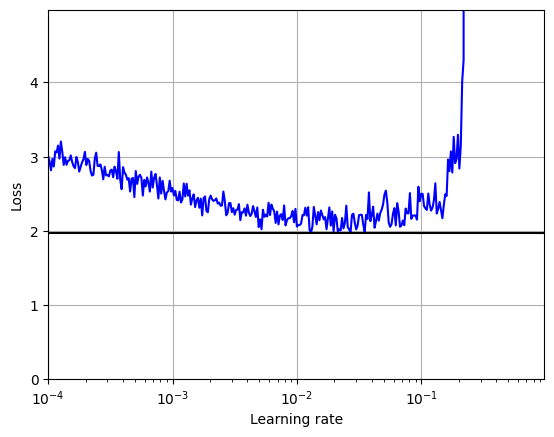

In [18]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train_wo_valid, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [19]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [22]:
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(X_train_scaled, y_train_wo_valid, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 3s 8ms/step - loss: 0.9172 - accuracy: 0.6737 - val_loss: 1.5780 - val_accuracy: 0.5262
Epoch 2/15
352/352 [==============================] - 3s 7ms/step - loss: 0.9556 - accuracy: 0.6598 - val_loss: 1.5980 - val_accuracy: 0.5116
Epoch 3/15
352/352 [==============================] - 3s 7ms/step - loss: 0.9925 - accuracy: 0.6430 - val_loss: 1.6024 - val_accuracy: 0.5036
Epoch 4/15
352/352 [==============================] - 3s 7ms/step - loss: 1.0321 - accuracy: 0.6345 - val_loss: 1.5871 - val_accuracy: 0.4934
Epoch 5/15
352/352 [==============================] - 3s 7ms/step - loss: 1.0664 - accuracy: 0.6222 - val_loss: 1.6241 - val_accuracy: 0.4998
Epoch 6/15
352/352 [==============================] - 3s 7ms/step - loss: 1.0919 - accuracy: 0.6134 - val_loss: 1.6735 - val_accuracy: 0.4810
Epoch 7/15
352/352 [==============================] - 3s 7ms/step - loss: 1.1019 - accuracy: 0.6113 - val_loss: 1.6469 - val_accuracy: 0.4762
Epoch 